In [1]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns

# For plotting and visualization:
from IPython.display import display
from textblob import TextBlob
from wordcloud import WordCloud
from credentials import *    # This will allow us to use the keys as variables
from textblob import TextBlob
from wordcloud import STOPWORDS
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import os
import nltk
#nltk.download('stopwords')

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE

#import xgboost as xgb
#import gensim

In [3]:
# Access:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)


def get_tweet_to_csv(filename, hashtaglist):
    csvFile = open(filename, 'a')
    #Use csv Writer
    csvWriter = csv.writer(csvFile)
    
    for tags in hashtaglist:
        for tweet in tweepy.Cursor(api.search, q=tags, count=1000, lang='en').items():
            csvWriter.writerow([tweet.id, tweet.created_at, tweet.text, tweet.source, tweet.favorite_count, tweet.retweet_count])

def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1
            return counter

def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))


In [4]:
def clean_tweets(tweets, remove_stopwords=False, stem=False):
    """
    to clean tweet strings
    tweet: a list of tweet strings
    remove_stop_words: whether to remove stop words
    output: a list of clean tweets
    """
    # 1. Remove HTML
    tweets_text = list(map(lambda x: BeautifulSoup(x, 'html.parser').get_text(), tweets))
    #
    # 2. Remove non-letters
    tweets_text = list(map(lambda x: re.sub("[^a-zA-Z]"," ", x), tweets_text))
    #
    # 3. Convert words to lower case and split them
    words = list(map(lambda x: x.lower().split(), tweets_text))
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        set_of_stopwords = set(stopwords.words("english"))
        meaningful_words = list(map(lambda x: [w for w in x if not w in set_of_stopwords], words))
    
    # 5. Optionally stem the words
    if stem:
        porter_stemmer = PorterStemmer()
        wordnet_lemmatizer = WordNetLemmatizer()
        stemmed_words = list(map(lambda x: [porter_stemmer.stem(w) for w in x], meaningful_words))
        stemmed_words = list(map(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x], stemmed_words))
    
        # 6. Join the words to a single string
        clean_tweet = map(lambda x: ' '.join(x), stemmed_words)
    else:
        clean_tweet = list(map(lambda x: ' '.join(x), meaningful_words))
    
    return clean_tweet

In [5]:
from textblob import TextBlob
import re

def clean_tweet(text):
    '''
    Utility function to clean the text in a tweet by removing links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

def analize_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet using textblob.
    '''
    analysis = TextBlob(clean_tweet(text))
    return analysis.sentiment.polarity


In [6]:
#scrape Yelp public review data for citibike # one time use only.
import requests
import re

rows = []
columns = ['yelp_review']
review_pattern = re.compile(r'"description":(.*?)", "author"')

for n in np.arange(0,16):
    x=n*20
    url = 'https://www.yelp.com/biz/citi-bike-new-york-6?start=%s'% x
    html = requests.get(url).text
    for this_review in re.findall(review_pattern, html):
        row = [this_review]
        rows.append(row)
        df = pd.DataFrame(rows, columns=columns)
    
# Use pandas to write the comma-separated output file
df.to_csv("yelp_review.csv", mode='a',  sep=',', quoting=0)   

In [7]:
#get twitter data
hashtaglist = ['#CitiBike','#citibike', '#bikenyc']

get_tweet_to_csv('citibike.csv',hashtaglist)

In [8]:
col_Names = ["id","created", "tweet","source","fav_count","retweet"]
data_tweet = pd.read_csv('citibike.csv', names=col_Names)

data_yelp1 = pd.read_csv('yelp_review.csv')
data_yelp = data_yelp1.drop(['Unnamed: 0'], axis=1)


# We display the first 10 elements of the dataframe:
display(data_tweet.info())
display(data_yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413 entries, 0 to 3412
Data columns (total 6 columns):
id           3413 non-null int64
created      3413 non-null object
tweet        3413 non-null object
source       3413 non-null object
fav_count    3413 non-null int64
retweet      3413 non-null int64
dtypes: int64(3), object(3)
memory usage: 160.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 1 columns):
yelp_review    3851 non-null object
dtypes: object(1)
memory usage: 30.2+ KB


None

In [9]:
data_tweet['len'] = data_tweet['tweet'].apply(len)
data_tweet['tweet_date'] = pd.to_datetime(data_tweet['created']).dt.date
    
data_tweet['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_tweet["tweet"]))
data_tweet['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_tweet["tweet"]))
data_tweet['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_tweet["tweet"]))
data_tweet['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_tweet["tweet"]))
data_tweet['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_tweet["tweet"]))

display(data_tweet.head(10))


data_yelp['len'] = data_yelp['yelp_review'].apply(len)
data_yelp['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_yelp["yelp_review"]))
data_yelp['hashtag_no'] = list(map(lambda txt: count_occurences("#", txt),data_yelp["yelp_review"]))
data_yelp['exclamation_no'] = list(map(lambda txt: count_occurences("!", txt),data_yelp["yelp_review"]))
data_yelp['question_no'] = list(map(lambda txt: count_occurences("?", txt),data_yelp["yelp_review"]))
data_yelp['mention_no'] = list(map(lambda txt: count_occurences("@", txt),data_yelp["yelp_review"]))

display(data_yelp.head(10))

,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,965963956400676864,2018-02-20 14:58:48,So proud that @motivate_co was just listed as ...,Twitter Web Client,6,3,140,2018-02-20,44,0,0,0,2
1,965777345050218496,2018-02-20 02:37:16,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0
2,965766482364911616,2018-02-20 01:54:07,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0
3,965631397951139841,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0
4,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1
5,965575650131181568,2018-02-19 13:15:49,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1
6,965575236593897477,2018-02-19 13:14:10,Pro Tip: Signal your turns and lane changes so...,Sprout Social,2,2,124,2018-02-19,34,2,0,0,0
7,965261142414290946,2018-02-18 16:26:04,New Yorkers- the only #childbikeseat that work...,Instagram,0,0,119,2018-02-18,35,2,0,0,0
8,965022780898054144,2018-02-18 00:38:54,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter for Android,0,2,140,2018-02-18,49,2,0,0,1
9,964863526954258432,2018-02-17 14:06:05,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter Web Client,0,2,140,2018-02-17,49,2,0,0,1


,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0
4,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0
5,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0
6,"""Deadly combo of raising rates whilst service...",384,90,0,2,0,0
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0


In [10]:
# Extract the mean of tweet lenghts:
mean = np.mean(data_tweet['len'])
print("The length's average in tweets: {}".format(mean))

# Extract the top tweets with most FAVs and more RTs:

fav_max = np.max(data_tweet['fav_count'])
rt_max  = np.max(data_tweet['retweet'])

fav = data_tweet[data_tweet.fav_count == fav_max].index[0]
rt  = data_tweet[data_tweet.retweet == rt_max].index[0]

# Max FAVs:
print("The tweet with most no of likes is: \n{}".format(data_tweet['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data_tweet['len'][fav]))

# Max RTs:
print("The tweet with most no of retweets is: \n{}".format(data_tweet['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data_tweet['len'][rt]))

The length's average in tweets: 129.8198066217404
The tweet with most no of likes is: 
If I can ride my bike on #QueensBlvd safely, at night, in the rain, in February, then anything is possible.… https://t.co/crTqIGy7EX
Number of likes: 85
132 characters.

The tweet with most no of retweets is: 
If I can ride my bike on #QueensBlvd safely, at night, in the rain, in February, then anything is possible.… https://t.co/crTqIGy7EX
Number of retweets: 22
132 characters.



In [11]:
# Create time series for data:

tlen = pd.Series(data=data_tweet['len'].values, index=data_tweet['created'])
tfav = pd.Series(data=data_tweet['fav_count'].values, index=data_tweet['created'])
tret = pd.Series(data=data_tweet['retweet'].values, index=data_tweet['created'])

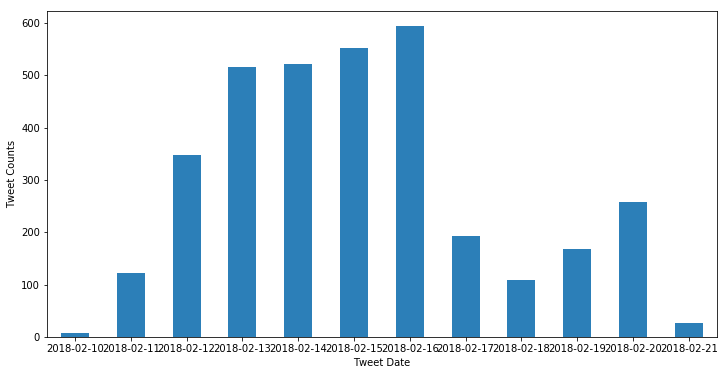

In [12]:
# No of Trips by Day:

df = data_tweet.groupby(['tweet_date']).agg({'id':'count'})
df.plot(kind = 'bar', figsize=(12, 6), color='#2c7fb8', linewidth=.03, label="No of Tweets", legend=False)
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Tweet Counts')
_ = plt.xlabel('Tweet Date')

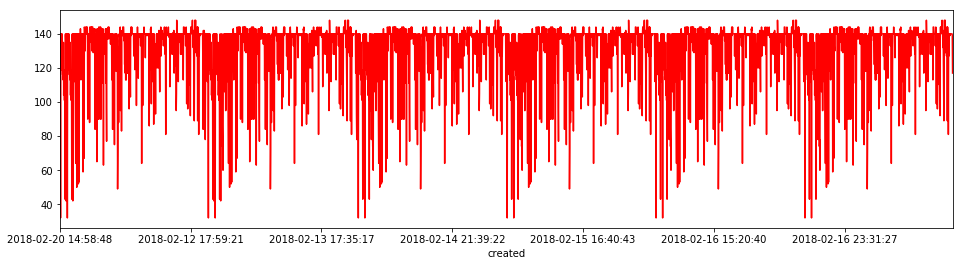

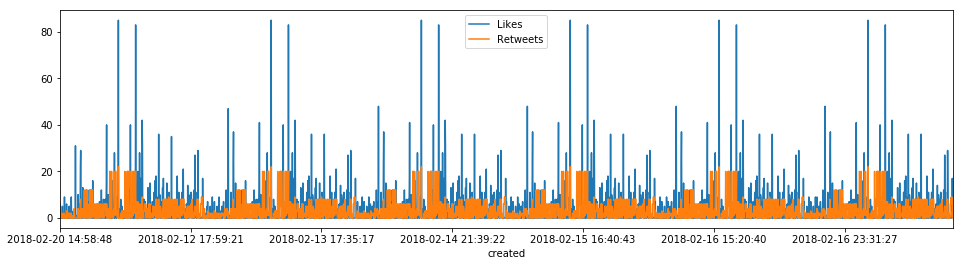

In [13]:
# Lenghts along time:
tlen.plot(figsize=(16,4), color='r');
plt.show()

# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);
plt.show()


In [14]:
# We obtain all possible sources:
sources = []
for source in data_tweet['source']:
    if source not in sources:
        sources.append(source)

# We print sources list:
print("Creation of content sources:")
for source in sources:
    print("* {}".format(source))

Creation of content sources:
* Twitter Web Client
* Instagram
* Twitter for iPhone
* Sprout Social
* Twitter for Android
* IFTTT
* Twitter Lite
* Hootsuite
* TweetDeck
* tofubot
* Reported_NYC
* Zapier.com
* Tweetbot for iΟS
* Buffer
* Twitter for iPad
* CyclingBot
* Talon Android
* Twitter for Mac
* Email Comps Verified
* AccBiking1
* Tweetbot for Mac
* ShouldIBikeToday
* Fenix 2 Preview
* Elysian Pedestrian Path


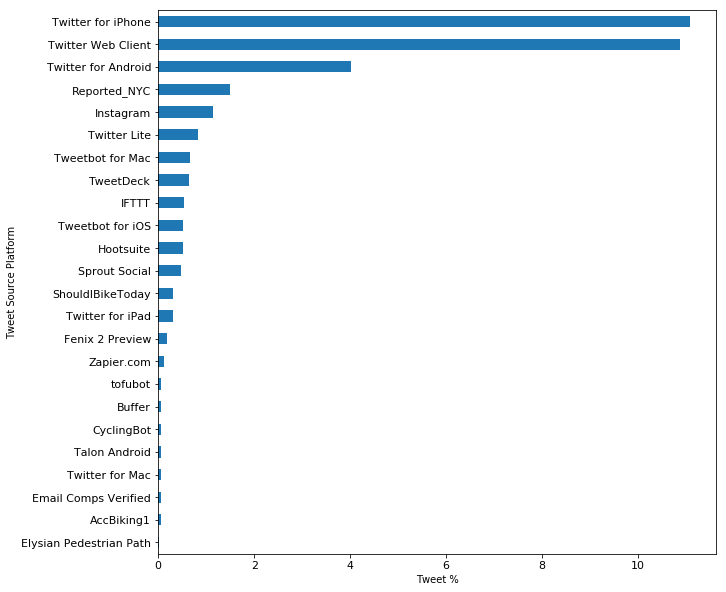

In [15]:
# Create a numpy vector mapped to labels:
percent = np.zeros(len(sources))

for source in data_tweet['source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

data = pd.Series(percent, index=sources, name='sources')
data.sort_values(ascending=True, inplace=True)

data.plot.barh(fontsize=11, figsize=(10, 10));
_ = plt.xlabel('Tweet %')
_ = plt.ylabel('Tweet Source Platform')

In [16]:
# We create a column with the result of the analysis:

#df_sub['free_trip'] = np.where(df_sub['tripduration'] <= 2700, 1, 0)
data_tweet['score'] = np.around(np.array([ analize_sentiment(tweet) for tweet in data_tweet['tweet'] ]),3)
data_tweet['SA'] = np.where(data_tweet['score'] > 0, 1, (np.where(data_tweet['score'] < 0, -1, 0)))

# We display the updated dataframe with the new column:
display(data_tweet.head(10))


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,965963956400676864,2018-02-20 14:58:48,So proud that @motivate_co was just listed as ...,Twitter Web Client,6,3,140,2018-02-20,44,0,0,0,2,0.600,1
1,965777345050218496,2018-02-20 02:37:16,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.000,0
2,965766482364911616,2018-02-20 01:54:07,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.000,0
3,965631397951139841,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.000,0
4,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
5,965575650131181568,2018-02-19 13:15:49,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter Web Client,0,2,140,2018-02-19,46,2,0,0,1,0.000,0
6,965575236593897477,2018-02-19 13:14:10,Pro Tip: Signal your turns and lane changes so...,Sprout Social,2,2,124,2018-02-19,34,2,0,0,0,0.000,0
7,965261142414290946,2018-02-18 16:26:04,New Yorkers- the only #childbikeseat that work...,Instagram,0,0,119,2018-02-18,35,2,0,0,0,0.068,1
8,965022780898054144,2018-02-18 00:38:54,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter for Android,0,2,140,2018-02-18,49,2,0,0,1,0.444,1
9,964863526954258432,2018-02-17 14:06:05,RT @CitiBikeNYC: Pro Tip: Wool socks will keep...,Twitter Web Client,0,2,140,2018-02-17,49,2,0,0,1,0.444,1


In [17]:

data_yelp['score'] = np.around(np.array([ analize_sentiment(review) for review in data_yelp['yelp_review'] ]),3)
data_yelp['SA'] = np.where(data_yelp['score'] > 0, 1, (np.where(data_yelp['score'] < 0, -1, 0)))
display(data_yelp.head(10))

,yelp_review,len,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,"""While Citi Bike can be a convenient way to g...",859,223,0,1,0,0,0.172,1
1,"""Had good experiences over the summer but not...",734,178,0,1,0,0,0.064,1
2,"""Great way to get around Brooklyn (\u0026 NYC...",420,104,0,0,0,0,0.126,1
3,"""I wanted to a rent a bike for sightseeing in...",439,113,0,1,0,0,0.076,1
4,"""Works like any other city bike rental BUT th...",579,159,0,0,0,0,0.002,1
5,"""A good idea in theory, with terrible executi...",1458,379,0,1,0,0,-0.086,-1
6,"""Deadly combo of raising rates whilst service...",384,90,0,2,0,0,0.225,1
7,"""This is a review of my annual membership. I ...",1169,276,0,1,0,0,0.163,1
8,"""UPDATE! \nWoke up to find I am being charged...",1028,295,0,12,0,0,0.231,1
9,"""I will never ever rent a bike from this comp...",174,43,0,0,0,0,0.133,1


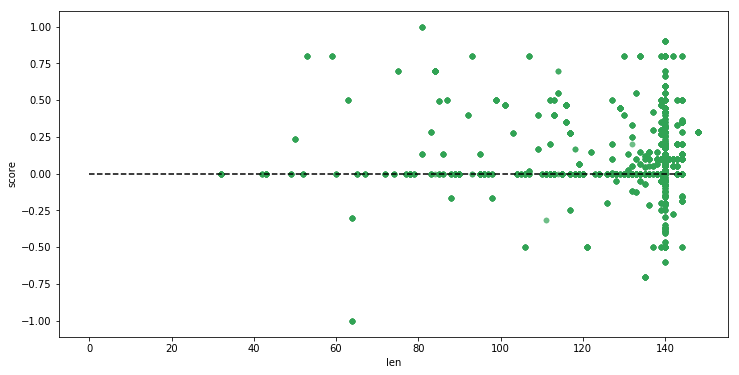

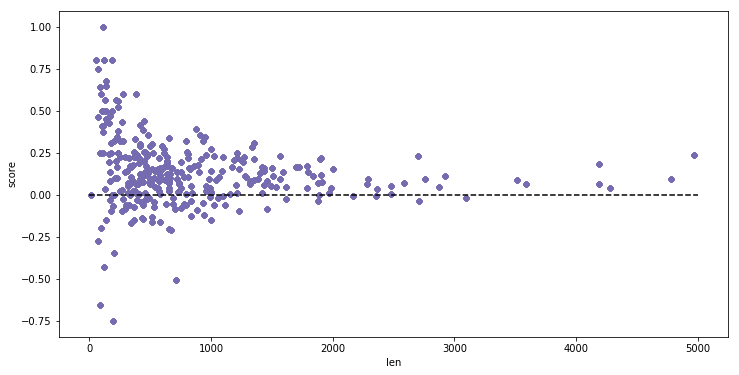

In [18]:
data_tweet.plot.scatter(x='len', y='score', figsize=(12, 6), color='#31a354', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 144], [0, 0], 'k--', color="Black")
plt.show()


data_yelp.plot.scatter(x='len', y='score', figsize=(12, 6), color='#756bb1', alpha=.7, linewidth=.3, s=30);
plt.plot([0, 5000], [0, 0], 'k--', color="Black")
plt.show()

In [19]:
# Construct lists with classified tweets:
pos_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] < 0]

In [20]:
# Print percentages:

pos_tweet_count = len(pos_tweets)*100/len(data_tweet['tweet'])
neu_tweet_count = len(neu_tweets)*100/len(data_tweet['tweet'])
neg_tweet_count = len(neg_tweets)*100/len(data_tweet['tweet'])
                                    
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data_tweet['tweet'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data_tweet['tweet'])))
print("Percentage for negative tweets: {}%".format(len(neg_tweets)*100/len(data_tweet['tweet'])))


Percentage of positive tweets: 44.76999707002637%
Percentage of neutral tweets: 41.517726340462936%
Percentage for negative tweets: 13.712276589510694%


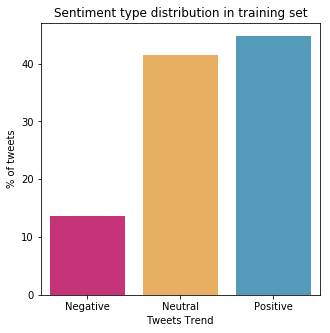

In [21]:
colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[neg_tweet_count, neu_tweet_count, pos_tweet_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% of tweets', xlabel='Tweets Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

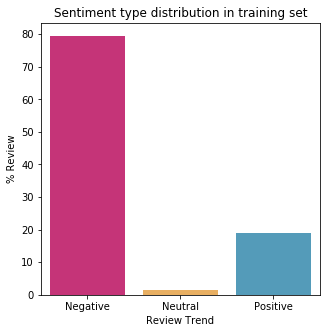

In [22]:
pos_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] > 0]
neu_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] == 0]
neg_review = [ review for index, review in enumerate(data_yelp['yelp_review']) if data_yelp['SA'][index] < 0]


pos_review_count = len(pos_review)*100/len(data_yelp['yelp_review'])
neu_review_count = len(neu_review)*100/len(data_yelp['yelp_review'])
neg_review_count = len(neg_review)*100/len(data_yelp['yelp_review'])

colors = ['#dd1c77','#feb24c','#43a2ca']
x_bar=["Negative","Neutral","Positive"]
y_bar=[pos_review_count, neu_review_count, neg_review_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% Review', xlabel='Review Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

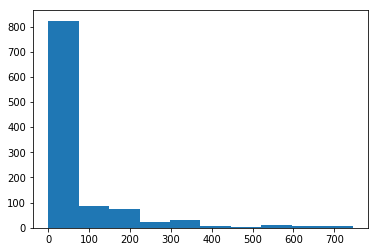

In [23]:
# Removing stopwords and punctuation for proper bigram creation

all_words3 = ', '.join(data_tweet.tweet)

# Combine all tweets and Split the script into lines: lines

for tweet in [all_words3] :
    
    lines = tweet.split('\n')

    # Replace all script lines for speaker
    pattern = "[A-Z]{2,}(\s)?(#\d)?([A-Z]{2,})?:"
    lines = [re.sub(pattern, '', l) for l in lines]

    # Tokenize each line: tokenized_lines
    tokenized_tweets = [regexp_tokenize(s, '\w+') for s in lines]

    # Make a frequency list of lengths: line_num_words
    line_num_words = [len(t_line) for t_line in tokenized_tweets]

    # Plot a histogram of the line lengths
    plt.hist(line_num_words)

# Show the plot
plt.show()

Single Cloud:


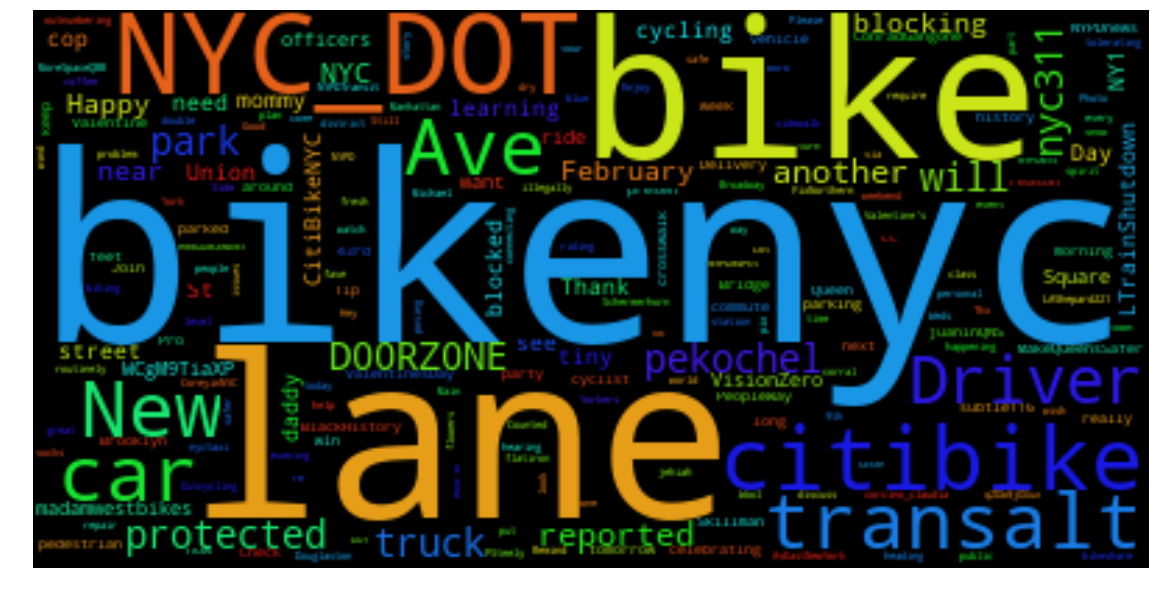

Bigrams:


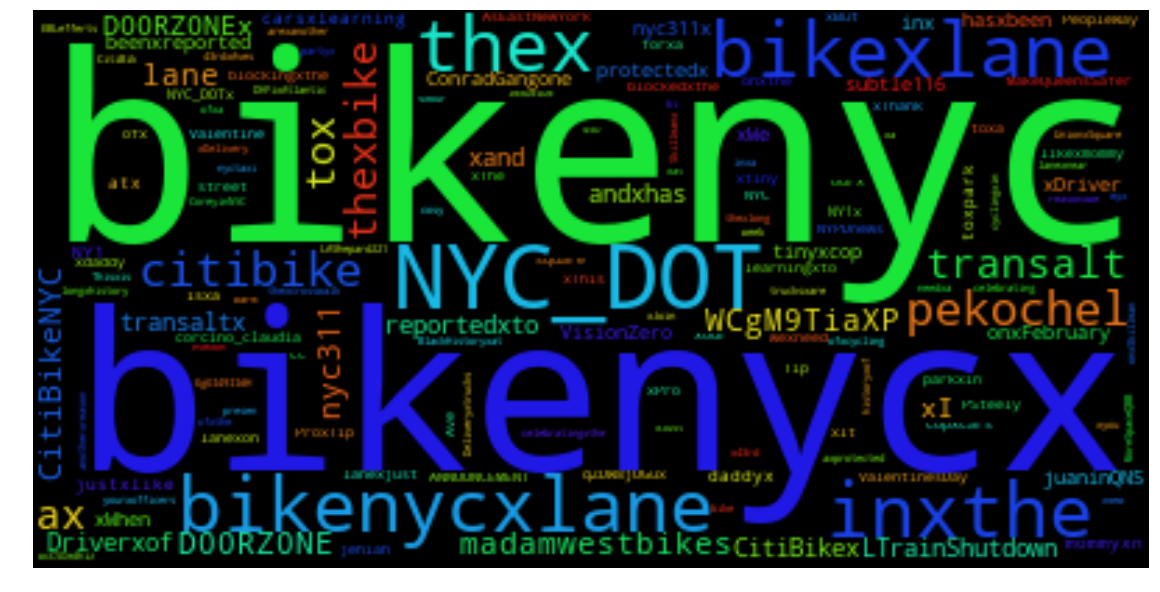

In [24]:
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram

stopwords1 = ['https', 'RT', 'http', '.co', 'amp']
for stopword in stopwords1:
    all_words3 = all_words3.replace(stopword,'')

words_bigram = bigram(all_words3)


# Single Cloud
wordcloud = WordCloud().generate(all_words3)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(words_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

In [25]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('citibike_data.xls', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
data_tweet.to_excel(writer, sheet_name='Sheet1')
# Close the Pandas Excel writer and output the Excel file.
writer.save()


# Now lets cleanup the twitter data

### Data Cleaning and Text Preprocessing

<div class="span25 alert alert-warning">
Here, header=0 indicates the first line of the tsv file contains the column names, delimiter="\t" means the file uses tap as delimiter, and quoting=3 tells Python to ignore double quotes.

Take a look at the training data.
</div>

<div class="span25 alert alert-info">
Removing HTML Markup with The BeautifulSoup Package.

Even though the review text is not in HTML, let's use the package BeautifulSoup.
<br> </br>
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
Convert words into lower case and tonkenize, i.e. split the text into individual words.

<br></br>

The reviews are now list of word strings.

</div>

In [26]:
data_tweet['tweet_bs'] = data_tweet['tweet'].apply(lambda x: BeautifulSoup(x, 'html.parser'))
data_tweet.tweet_bs[0].get_text()

data_tweet['tweet_letters_only'] = data_tweet['tweet_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))
data_tweet['tweet_letters_only'][0]

data_tweet['tweet_words'] = data_tweet['tweet_letters_only'].apply(lambda x: x.lower().split())
data_tweet['tweet_words'][0]

['so',
 'proud',
 'that',
 'motivate',
 'co',
 'was',
 'just',
 'listed',
 'as',
 'fastcompany',
 's',
 'most',
 'innovative',
 'companies',
 'honorees',
 'by',
 'sector',
 'soc',
 'https',
 't',
 'co',
 'nkyojycxpk']

In [27]:
train = pd.read_excel('citibike_data.xls', header=0, delimiter="\t", quoting=3)
print('Dimension of Labeled Training Data: {}.'.format(train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(train.shape[0], train.shape[1]))

display(train.head())
print(train.tweet[0])

Dimension of Labeled Training Data: (3413, 15).
There are 3413 samples and 15 variables in the training data.


,id,created,tweet,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA
0,965963956400676864,2018-02-20 14:58:48,So proud that @motivate_co was just listed as ...,Twitter Web Client,6,3,140,2018-02-20,44,0,0,0,2,0.6,1
1,965777345050218496,2018-02-20 02:37:16,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.0,0
2,965766482364911616,2018-02-20 01:54:07,ADVENTURES IN UNION SQUARE\n.\n.\n.\n#chunkykn...,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.0,0
3,965631397951139840,2018-02-19 16:57:20,Just activated my #citibike key!,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.0,0
4,965585950318497792,2018-02-19 13:56:44,RT @CitiBikeNYC: Pro Tip: Signal your turns an...,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.0,0


So proud that @motivate_co was just listed as @FastCompany's Most Innovative Companies 2018 Honorees By Sector: Soc… https://t.co/nkyojYCxpk


<div class="span25 alert alert-info">
Remove stop words with ntlk and as the final step, join the list of words into a single string.
</div>

In [28]:
set_of_stopwords = set(stopwords.words("english"))
data_tweet['tweet_meaningful_words'] = data_tweet['tweet_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

num_removed = len(data_tweet['tweet_words'][0]) - len(data_tweet['tweet_meaningful_words'][0])
print('For the first Tweet, the number of stop words removed is {0}.'.format(num_removed))

data_tweet['tweet_cleaned'] = data_tweet['tweet_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

For the first Tweet, the number of stop words removed is 9.


<div class="span25 alert alert-info">
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
<br> </br>
The reviews are now strings of letters only.
</div>

In [29]:
data_tweet.drop(['tweet', 'tweet_bs', 'tweet_letters_only', 'tweet_words', 'tweet_meaningful_words'], 
           axis=1, inplace=True)
display(data_tweet.head())
print(data_tweet['tweet_cleaned'][0])

,id,created,source,fav_count,retweet,len,tweet_date,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,score,SA,tweet_cleaned
0,965963956400676864,2018-02-20 14:58:48,Twitter Web Client,6,3,140,2018-02-20,44,0,0,0,2,0.6,1,proud motivate co listed fastcompany innovativ...
1,965777345050218496,2018-02-20 02:37:16,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.0,0,adventures union square chunkyknit wiwt citibi...
2,965766482364911616,2018-02-20 01:54:07,Instagram,0,0,115,2018-02-20,59,6,0,0,0,0.0,0,adventures union square chunkyknit wiwt citibi...
3,965631397951139841,2018-02-19 16:57:20,Twitter for iPhone,1,0,32,2018-02-19,7,1,1,0,0,0.0,0,activated citibike key
4,965585950318497792,2018-02-19 13:56:44,Twitter for iPhone,0,2,140,2018-02-19,46,2,0,0,1,0.0,0,rt citibikenyc pro tip signal turns lane chang...


proud motivate co listed fastcompany innovative companies honorees sector soc https co nkyojycxpk


In [30]:
# Removing stopwords and punctuation for proper bigram creation after all cleanups

clean_tweets = ', '.join(data_tweet.tweet_cleaned)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram


stopwords1 = ['https', 'http', '.co', 'co', 'rt', 'dot']
for stopword in stopwords1:
    clean_tweets = clean_tweets.replace(stopword,'')
    
words_bigram = bigram(clean_tweets)

Single Cloud:


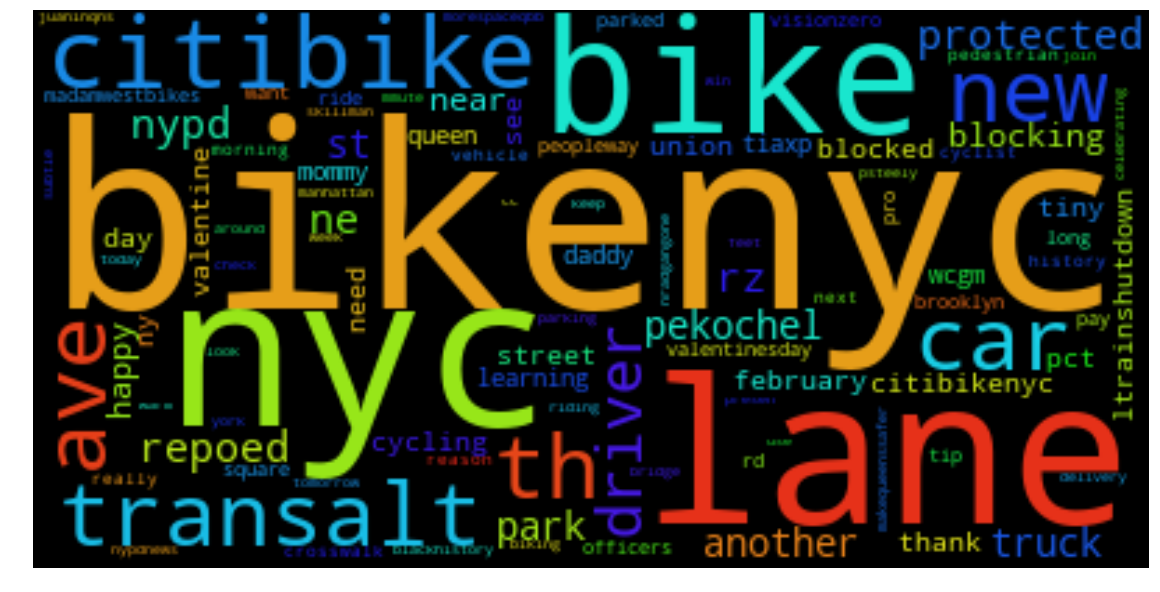

Bigrams:


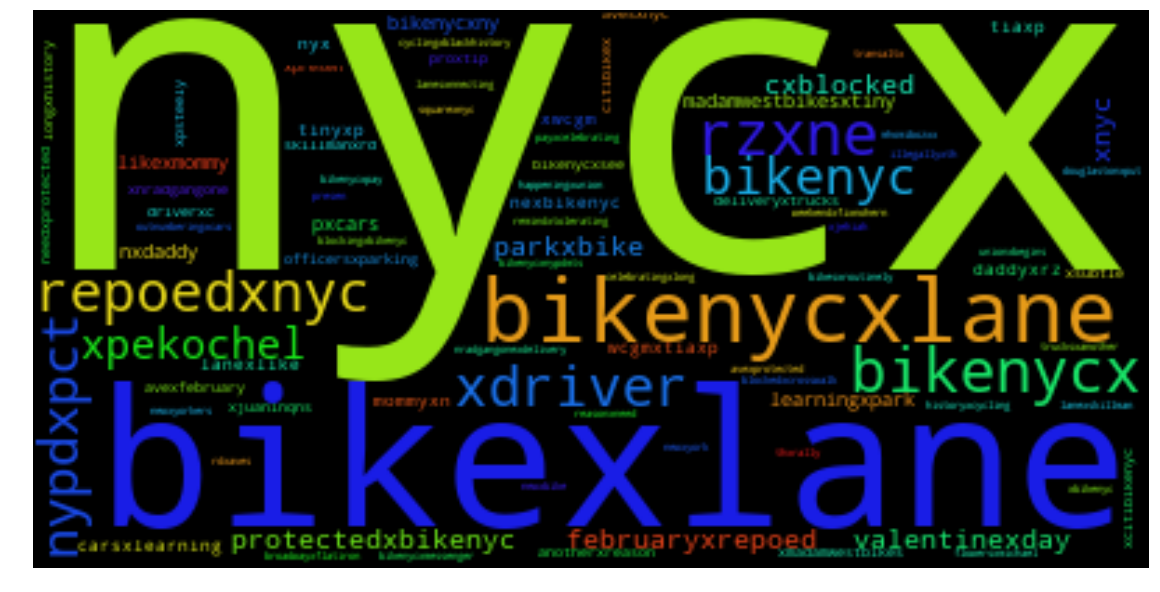

In [31]:
# Single Cloud
wordcloud = WordCloud().generate(clean_tweets)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(words_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

<div class="span25 alert alert-info">
Now the training data is ready for using Bag of Words Analysis.
<br></br>
<br></br>
Initialize the CountVectorizer object, which is scikit-learn's bag of words tool. CountVectorizer converts a collection of text documents to a matrix of token counts.
</div>


## Creating Features from a Bag of Words (Using scikit-learn)¶


In [32]:
vectorizer = CountVectorizer(analyzer="word", preprocessor=None, tokenizer=None, stop_words=None, max_features=5000)

In [33]:
#data_features = vectorizer.fit_transform(list(data_tweet['tweet_cleaned'].values))
#print(list(data_tweet['tweet_cleaned'].values)[3])
#bow = vectorizer.transform(list(data_tweet['tweet_cleaned'].values)[3])

# Numpy arrays are easy to work with, so convert the result to an array
data_features = list(data_tweet['tweet_cleaned'].values)
data_target = list(data_tweet['SA'].values)

F_train, F_test, T_train, T_test = train_test_split(data_features, data_target, test_size = 0.3, random_state=42)


In [34]:
#tweet_vocab = vectorizer.get_feature_names()
#messages_bow = vectorizer.transform(list(data_tweet['tweet_cleaned'].values))

messages_bow = vectorizer.fit_transform(F_train)
test_bow = vectorizer.transform(F_test)

print ('Shape of Sparse Matrix: ', messages_bow.shape)
print ('Amount of Non-Zero occurences: ', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz /
                             (messages_bow.shape[0] * messages_bow.shape[1])))
print(messages_bow.shape)
print(test_bow.shape)

Shape of Sparse Matrix:  (2389, 2071)
Amount of Non-Zero occurences:  33242
sparsity: 0.67%
(2389, 2071)
(1024, 2071)


In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.fit_transform(messages_bow)
print(messages_tfidf.shape)

tfidf_transformer1 = TfidfTransformer().fit(test_bow)
test_tfidf = tfidf_transformer1.fit_transform(test_bow)
print(test_tfidf.shape)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(messages_tfidf, T_train)

predicted = clf.predict(test_tfidf)

print(np.mean(predicted == T_test))

(2389, 2071)
(1024, 2071)
0.9853515625


## Random Forest
Let's try a random forest with the features we just created.

In [36]:
# Initialize a Random Forest classifier with 100 trees
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as labels
# This may take a few minutes to run
rf_clf.fit(messages_tfidf, T_train)
result = rf_clf.predict(test_tfidf)

print(np.mean(result == T_test))

0.9765625


In [37]:
print("confusion matrix: ",confusion_matrix(T_test, result))
print("classification report: ", classification_report(T_test, result))


confusion matrix:  [[138   0   1]
 [  0 413   6]
 [  1  16 449]]
classification report:               precision    recall  f1-score   support

         -1       0.99      0.99      0.99       139
          0       0.96      0.99      0.97       419
          1       0.98      0.96      0.97       466

avg / total       0.98      0.98      0.98      1024



In [38]:
tweet_train, tweet_test, label_train, label_test = \
train_test_split(list(data_tweet['tweet_cleaned'].values), list(data_tweet['SA'].values), test_size=0.2)

print (len(tweet_train), len(tweet_test), len(tweet_train) + len(tweet_test))

2730 683 3413


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from pprint import pprint
from time import time
import logging

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', tol=None)),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (500, 2000, 5000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.001, 0.0001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 100),
}


if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a main block / " __main__" protected block
    # find the best parameters for both the feature extraction and the classifier
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    
    pprint(parameters)
    t0 = time()
    #grid_search.fit(X_new, y_new)
    grid_search.fit(tweet_train, label_train)
    

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__n_iter': (10, 50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (500, 2000, 5000),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  4.4min finished


In [40]:
print("done in %0.3fs" % (time() - t0))
print("-----")
print("Best score: %0.3f" % grid_search.best_score_)
print("Best Model:",  grid_search.best_estimator_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


done in 262.904s
-----
Best score: 0.997
Best Model: Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...cnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])
Best parameters set:
	clf__alpha: 0.0001
	clf__n_iter: 10
	clf__penalty: 'elasticnet'
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__max_features: 2000
	vect__ngram_range: (1, 1)


In [41]:
predicted = grid_search.predict(tweet_test)
print(np.mean(predicted == label_test))   

print("confusion matrix: ",confusion_matrix(label_test, predicted))
print("classification report: ", classification_report(label_test, predicted))

1.0
confusion matrix:  [[104   0   0]
 [  0 275   0]
 [  0   0 304]]
classification report:               precision    recall  f1-score   support

         -1       1.00      1.00      1.00       104
          0       1.00      1.00      1.00       275
          1       1.00      1.00      1.00       304

avg / total       1.00      1.00      1.00       683



In [42]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(label_train, grid_search.predict(tweet_train)),
    mean_absolute_error(label_test, predicted)))
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(label_train, grid_search.predict(tweet_train)),
    mean_squared_error(label_test, predicted)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(label_train, grid_search.predict(tweet_train)),
    r2_score(label_test, predicted))))

MAE train: 0.000, test: 0.000
MSE train: 0.000, test: 0.000
R^2 train: 1.000, test: 1.000


In [43]:
# Models to try
models = {
    'RF': RandomForestClassifier( oob_score = True ),
    'LR' : LogisticRegression(),
}

# Parameters to try (this is not an exahustive GridSearch)

params = {
    'RF': {'n_estimators' : [1000, 2000],
            'max_depth': [6, 12],
            'min_samples_leaf': [1, 3],
            'max_features': [1.0, 0.3]},
    'LR' : {'penalty' : ['l1', 'l2'],
            'class_weight' : ['balanced']},
}

In [44]:
class EstimatorSelectionHelper:
    
    """
    A helper class for running parameter grid search across different models. 
    It takes two dictionaries. The first contains the models to be scored. 
    The second contains the parameters for each model
    """
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False): 
        """
        fit(X,y) method runs a parameter grid search with cross validation for each model
        and for the given training data. If scoring=None, the score method of the estimator is used.
        """
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs 
            
    
    
    def score_summary(self, sort_by='mean_score'):
        """
        After calling fit(X,y), the score_summary() method returns a df with a summary of the scores
        """
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                }

            return pd.Series(dict(list( params.items()) + list(d.items() ))) #sum up two dicts
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

In [45]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(messages_tfidf, T_train, n_jobs=-1)


Running GridSearchCV for RF.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.5min finished


Running GridSearchCV for LR.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.3s finished


In [46]:
helper.score_summary()


,estimator,min_score,mean_score,max_score,std_score,class_weight,max_depth,max_features,min_samples_leaf,n_estimators,penalty
17,LR,0.97867,0.982417,0.988708,0.00447504,balanced,NaN,NaN,NaN,NaN,l2
16,LR,0.912171,0.916285,0.918444,0.00291021,balanced,NaN,NaN,NaN,NaN,l1
13,RF,0.818068,0.832558,0.856964,0.0173584,NaN,12,0.3,1,2000,NaN
9,RF,0.803774,0.832542,0.854454,0.0212506,NaN,12,1,1,2000,NaN
8,RF,0.794969,0.830862,0.856964,0.0262392,NaN,12,1,1,1000,NaN
12,RF,0.81761,0.829208,0.851945,0.0160788,NaN,12,0.3,1,1000,NaN
11,RF,0.788679,0.810781,0.841907,0.0226478,NaN,12,1,3,2000,NaN
10,RF,0.783648,0.810359,0.843162,0.0246755,NaN,12,1,3,1000,NaN
15,RF,0.806289,0.809959,0.816813,0.00485043,NaN,12,0.3,3,2000,NaN
14,RF,0.803774,0.809539,0.816813,0.0054292,NaN,12,0.3,3,1000,NaN


In [47]:
reg = RandomForestClassifier(n_estimators=1000, n_jobs=2, random_state=42, min_samples_leaf=1, max_features = 1) 

reg.fit(messages_tfidf, T_train)

y_pred = reg.predict(test_tfidf)


In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

accuracy = accuracy_score(T_test, y_pred)

print(accuracy)
print(np.mean(result == T_test))

cv_scores = cross_val_score(reg, test_tfidf, T_test, cv=10)

# Print the 5-fold cross-validation scores

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

0.9970703125
0.9765625
Average 5-Fold CV Score: 0.9610020940415002


In [49]:
logreg = LogisticRegression()

# Setup the hyperparameter grid
c_space = np.logspace(0, 3, 7)
param_grid = {'C': c_space, 'penalty': ['l2'], 'class_weight':['balanced']}

# Instantiate the logistic regression classifier with Grid Search
logreg_cv = GridSearchCV(logreg, param_grid, cv=3)

# Fit the classifier to the training data
logreg_cv.fit(messages_tfidf, T_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# Predict the target of the test set
target_pred = logreg_cv.predict(test_tfidf)

Tuned Logistic Regression Parameters: {'C': 3.1622776601683795, 'class_weight': 'balanced', 'penalty': 'l2'}
Best score is 0.988698200083717


In [50]:
cv_scores_lr = cross_val_score(logreg_cv, test_tfidf, T_test, cv=10)

# Print the 5-fold cross-validation scores

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores_lr)))

Average 5-Fold CV Score: 0.9648665524462212
